# Visualizing Score Functions and Langevin Monte Carlo in 2D Gaussian Mixtures
## 概要

このノートブックでは、**スコア関数**と**ランジュバンモンテカルロ（LMC**サンプリングを**2D混合ガウス分布モデル（GMM**内で視覚的に探求します。
以下の内容を学ぶことができます：
1. **Define and Plot a 2D Gaussian Mixture**
2. **Compute and Visualize the Score Vector Field**
3. **Perform Langevin Monte Carlo Sampling**: スコアを利用することでp(x)からのサンプリングができることを確認
4. **Estimate and Compare Density Functions**


インタラクティブなプロットを通じて、スコア関数がサンプリングプロセスをどのように導き、LMCが複雑な分布をどのように効果的に探索するかについて直感的な理解を深めることができます。

## Contents

1. [Setup and GMM Definition](#Setup-and-GMM-Definition)
2. [Plotting the Gaussian Mixture](#Plotting-the-Gaussian-Mixture)
3. [Score Vector Field](#Score-Vector-Field)
4. [Langevin Monte Carlo Sampling](#Langevin-Monte-Carlo-Sampling)
5. [Density Estimation and Comparison](#Density-Estimation-and-Comparison)



# Setup-and-GMM-Definition

### Score

In the context of probability distributions, the **score function** is defined as the gradient of the logarithm of the probability density function (PDF). Mathematically, for a distribution $ p(\mathbf{x}) $, the score function is:

$$
\nabla \log p(\mathbf{x})
$$

This function points in the direction of the steepest increase in the log-probability density, effectively indicating how to adjust \(\mathbf{x}\) to reach regions of higher probability.

補足
- 対数尤度の入力xについての勾配
- 対数尤度が最も急激に大きくなる方向とその大きさ
- 確率が最も急激に上昇するベクトルを確率で割った値

多変量正規分布の場合の勾配

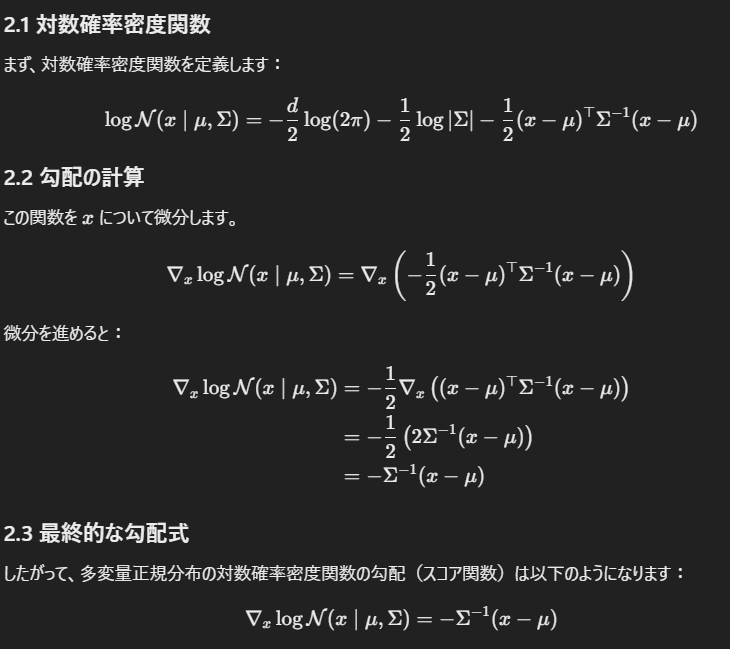

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde, multivariate_normal


# 1. 2次元混合ガウス分布の定義
class GaussianMixture:
    def __init__(self, means, covariances, weights):
        """
        means: リストまたは配列、各ガウス分布の平均 (dim, )
        covariances: リストまたは配列、各ガウス分布の共分散行列 (dim, dim)
        weights: 各ガウス分布の混合係数 (合計で1)
        """
        self.means = means
        self.covariances = covariances
        self.weights = weights
        self.num_components = len(weights)
        self.dim = means[0].shape[0]
        # Precompute the multivariate normal distributions
        self.components = [
            multivariate_normal(mean=means[i], cov=covariances[i])
            for i in range(self.num_components)
        ]

    def pdf(self, x):
        """
        確率密度関数の計算
        x: (..., dim)
        """
        pdf_vals = np.zeros(x.shape[:-1])
        for w, comp in zip(self.weights, self.components):
            pdf_vals += w * comp.pdf(x)
        return pdf_vals

    def score(self, x):
        """
        スコア関数（log p(x) の勾配）の計算
        x: (..., dim)
        Returns: (..., dim)
        """
        p = self.pdf(x)
        # To avoid division by zero
        p = np.maximum(p, 1e-12)
        score = np.zeros_like(x)
        for w, mean, cov, comp in zip(
            self.weights, self.means, self.covariances, self.components
        ):
            # Compute (−Σ^{-1}(x - μ)) for each component
            inv_cov = np.linalg.inv(cov)
            diff = x - mean  # Shape: (num_samples, dim)
            component_score = -diff @ inv_cov  # Shape: (num_samples, dim)
            score += w * comp.pdf(x)[:, None] * component_score
        score /= p[:, None]
        return score


# 2. 混合ガウスのパラメータ設定
means = [np.array([0, -2]), np.array([3, 1]), np.array([-3, 1])]
covariances = [
    np.array([[1, 0.5], [0.5, 1]]),
    np.array([[1, -0.3], [-0.3, 1]]),
    np.array([[1, 0], [0, 1]]),
]
weights = [0.4, 0.3, 0.3]

gmm = GaussianMixture(means, covariances, weights)

# Plotting-the-Gaussian-Mixture

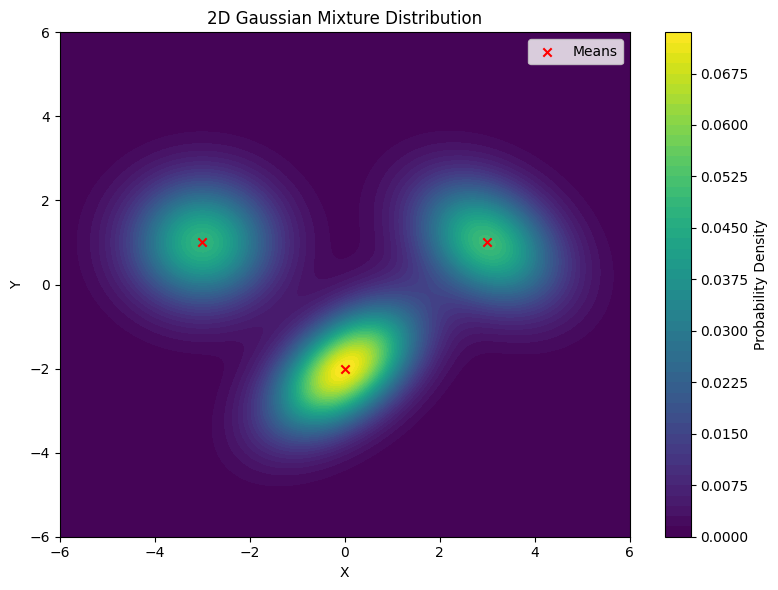

In [3]:
# 3. グリッドの範囲を統一
x_min, x_max = -6, 6
y_min, y_max = -6, 6

# グリッドを作成して確率密度を計算
grid_points_per_axis = 200  # 解像度の設定
x = np.linspace(x_min, x_max, grid_points_per_axis)
y = np.linspace(y_min, y_max, grid_points_per_axis)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
Z = gmm.pdf(pos)

# 4. 混合ガウス分布のプロット
plt.figure(figsize=(8, 6))
contour_levels = 50
contourf = plt.contourf(X, Y, Z, levels=contour_levels, cmap="viridis")
plt.colorbar(contourf, label="Probability Density")
plt.title("2D Gaussian Mixture Distribution")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(*zip(*means), c="red", marker="x", label="Means")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.tight_layout()
plt.show()

# Score-Vector-Field


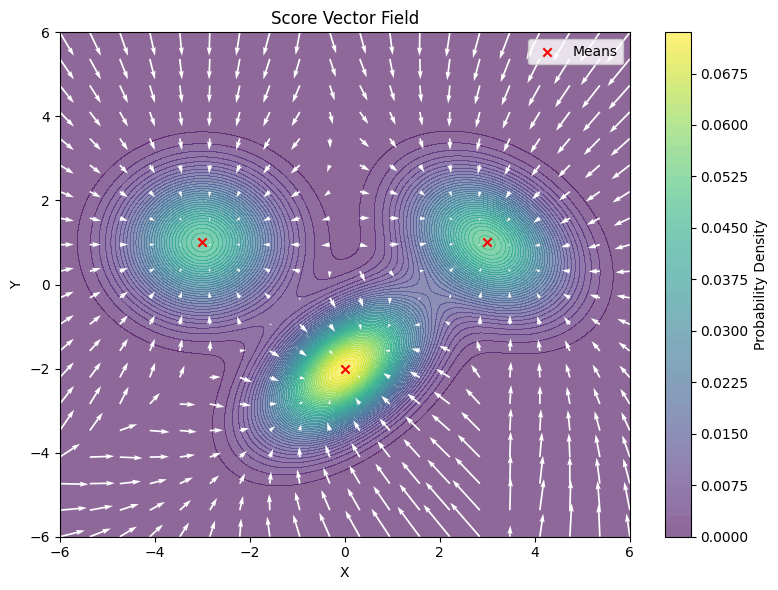

In [4]:
# 5. スコアベクトル場のプロット
# グリッドポイントをサンプリング
vector_field_size = 20  # ベクトル場の密度
x_grid = np.linspace(x_min, x_max, vector_field_size)
y_grid = np.linspace(y_min, y_max, vector_field_size)
Xg, Yg = np.meshgrid(x_grid, y_grid)
grid_points = np.vstack([Xg.ravel(), Yg.ravel()]).T

# スコアの計算
scores = gmm.score(grid_points)

# プロット
plt.figure(figsize=(8, 6))
contourf = plt.contourf(X, Y, Z, levels=contour_levels, cmap="viridis", alpha=0.6)
plt.colorbar(contourf, label="Probability Density")
plt.quiver(
    grid_points[:, 0], grid_points[:, 1], scores[:, 0], scores[:, 1], color="white"
)
plt.title("Score Vector Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(*zip(*means), c="red", marker="x", label="Means")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.tight_layout()
plt.show()


# Langevin-Monte-Carlo-Sampling

## Langevin Monte Carlo (LMC)

#### Continuous Langevin Dynamics

The continuous-time Langevin dynamics are governed by the stochastic differential equation (SDE):

$$
d\mathbf{x}_t = \nabla \log p(\mathbf{x}_t) \, dt + \sqrt{2} \, d\mathbf{W}_t
$$

- $\mathbf{x}_t$: Position of the particle at time $t$.
- $p(\mathbf{x})$: Target probability density function.
- $\nabla \log p(\mathbf{x}_t)$: **Score function**, representing the gradient of the log-density.
- $d\mathbf{W}_t$: Wiener process (standard Brownian motion).

This equation balances the **drift term** ($\nabla \log p(\mathbf{x}_t)$), which guides the particle towards regions of higher probability density, and the **diffusion term** ($\sqrt{2} \, d\mathbf{W}_t$), which introduces randomness to ensure thorough exploration of the distribution.

#### Discrete-Time Approximation

In practice, continuous Langevin dynamics are approximated using discrete-time updates, leading to the **Langevin Monte Carlo** algorithm. The discrete update rule is given by:

$$
\mathbf{x}_{k+1} = \mathbf{x}_k + \frac{\epsilon}{2} \nabla \log p(\mathbf{x}_k) + \sqrt{\epsilon} \, \boldsymbol{\eta}_k
$$

- $k$: Iteration index.
- $\epsilon$: Step size (learning rate).
- $\boldsymbol{\eta}_k$: Standard Gaussian noise, $\boldsymbol{\eta}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

This update rule consists of two components:

1. **Gradient Ascent Step**: $\frac{\epsilon}{2} \nabla \log p(\mathbf{x}_k)$
   - Moves the sample in the direction of increasing probability density.
   - The step size $\epsilon$ controls the magnitude of this movement.

2. **Stochastic Noise**: $\sqrt{\epsilon} \, \boldsymbol{\eta}_k$
   - Introduces randomness to escape local maxima and explore the distribution.
   - The noise magnitude is proportional to $\sqrt{\epsilon}$, ensuring a balance between exploration and exploitation.

### Implementation in 2D Gaussian Mixture Models

In the context of a **2D Gaussian Mixture Model (GMM)**, LMC iteratively updates sample positions to converge towards regions of high probability density defined by the mixture components.

#### Step-by-Step Process

1. **Initialization**:
   - Start with an initial set of samples $\{\mathbf{x}_0^{(i)}\}_{i=1}^{N}$, typically drawn from a uniform distribution over a predefined range.

2. **Iterative Updates**:
   - For each sample $\mathbf{x}_k^{(i)}$, compute the score function $\nabla \log p(\mathbf{x}_k^{(i)})$.
   - Update the sample using the discrete-time Langevin equation:
     $$
     \mathbf{x}_{k+1}^{(i)} = \mathbf{x}_k^{(i)} + \frac{\epsilon}{2} \nabla \log p(\mathbf{x}_k^{(i)}) + \sqrt{\epsilon} \, \boldsymbol{\eta}_k^{(i)}
     $$
   - Repeat for a specified number of iterations to allow samples to converge.

3. **History Tracking**:
   - Record the trajectory of each sample across iterations to visualize the sampling dynamics and convergence behavior.

4. **Density Estimation**:
   - After sufficient iterations, use the final set of samples to estimate the density of the target distribution via techniques like **Kernel Density Estimation (KDE)**.
   - Compare the estimated density with the original GMM to assess the quality of sampling.



In [5]:
# 6. ランジュバンモンテカルロ法によるサンプリングと履歴の保持
def langevin_monte_carlo_history(
    score_func, num_samples, num_steps, step_size, initial_pos
):
    """
    score_func: スコア関数を計算する関数
    num_samples: サンプル数
    num_steps: 各サンプルのステップ数
    step_size: ランジアンのステップサイズ
    initial_pos: 初期位置の配列 (num_samples, dim)
    Returns:
        history: 各ステップの位置を保持する配列 (num_steps + 1, num_samples, dim)
        final_samples: 最終的なサンプル位置 (num_samples, dim)
    """
    history = np.zeros((num_steps + 1, num_samples, initial_pos.shape[1]))
    history[0] = initial_pos
    samples = initial_pos.copy()
    for step in range(1, num_steps + 1):
        scores = score_func(samples)  # type scores: (num_samples, dim)
        noise = np.random.randn(*samples.shape) * np.sqrt(2 * step_size)
        samples += step_size * scores + noise
        # 位置を範囲内にクリップ（オプション）
        samples[:, 0] = np.clip(samples[:, 0], x_min, x_max)
        samples[:, 1] = np.clip(samples[:, 1], y_min, y_max)
        history[step] = samples
    return history, samples


# パラメータ設定
num_samples = 500
num_steps = 100
step_size = 0.1
initial_pos = np.random.uniform(
    low=[x_min, y_min], high=[x_max, y_max], size=(num_samples, 2)
)

# サンプリング実行
history, final_samples = langevin_monte_carlo_history(
    gmm.score, num_samples, num_steps, step_size, initial_pos
)


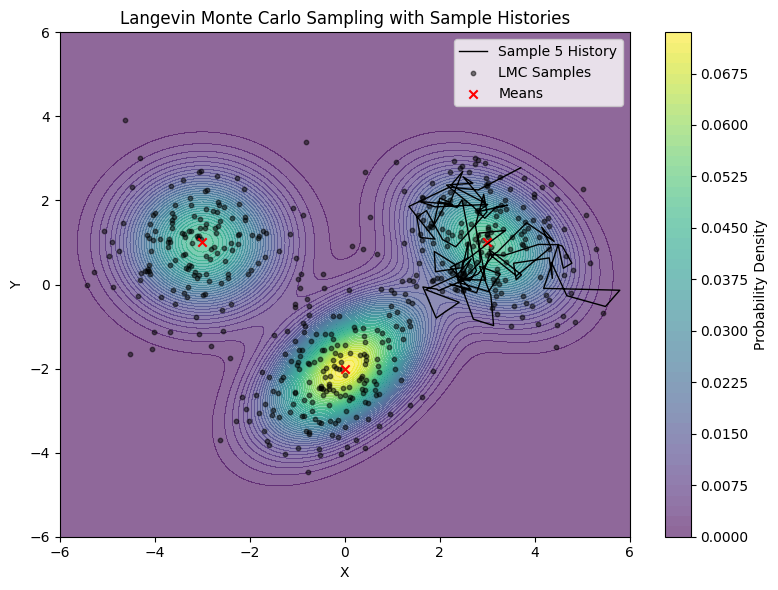

In [19]:
# 7. サンプリング結果のプロットと履歴の表示
plt.figure(figsize=(8, 6))
contourf = plt.contourf(X, Y, Z, levels=contour_levels, cmap="viridis", alpha=0.6)
plt.colorbar(contourf, label="Probability Density")

# 全サンプルの履歴をプロット（透明度を設定）
# for i in range(num_samples):
#     plt.plot(history[:, i, 0], history[:, i, 1], color="white", alpha=0.1)

# 5番目のサンプルの履歴を強調表示
sample_index = 4  # 0-based index
plt.plot(
    history[:, sample_index, 0],
    history[:, sample_index, 1],
    color="black",
    linewidth=1,
    # marker=".",
    label="Sample 5 History",
)

# 最終的なサンプル位置をプロット
plt.scatter(
    final_samples[:, 0],
    final_samples[:, 1],
    c="black",
    s=10,
    alpha=0.5,
    label="LMC Samples",
)
plt.title("Langevin Monte Carlo Sampling with Sample Histories")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(*zip(*means), c="red", marker="x", label="Means")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()
plt.tight_layout()
plt.show()

# Density-Estimation-and-Comparison

In [ ]:
# 8. サンプルからの密度推定とp(x)との比較
# カーネル密度推定（KDE）の実行
kde = gaussian_kde(final_samples.T)  # Transpose to shape (dim, num_samples)

# KDEによる推定密度の計算
Z_kde = kde(np.vstack([X.ravel(), Y.ravel()]))
Z_kde = Z_kde.reshape(X.shape)

# プロット
plt.figure(figsize=(12, 6))

# 元の分布 p(x) のプロット
plt.subplot(1, 2, 1)
contourf_p = plt.contourf(X, Y, Z, levels=contour_levels, cmap="viridis")
plt.colorbar(contourf_p, label="p(x)")
plt.title("Original Gaussian Mixture Distribution p(x)")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(*zip(*means), c="red", marker="x", label="Means")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

# サンプルから推定した密度のプロット
plt.subplot(1, 2, 2)
contourf_kde = plt.contourf(X, Y, Z_kde, levels=contour_levels, cmap="viridis")
plt.colorbar(contourf_kde, label="Estimated Density from LMC Samples")
plt.title("Estimated Density from LMC Samples")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(
    final_samples[:, 0],
    final_samples[:, 1],
    c="white",
    s=10,
    alpha=0.5,
    label="LMC Samples",
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend()

plt.tight_layout()
plt.show()

# 9. 元のp(x)と推定密度の重ね合わせプロット
plt.figure(figsize=(8, 6))
# 元のp(x)の等高線
contours_p = plt.contour(X, Y, Z, levels=10, colors="blue", linestyles="dashed")
# 推定密度の等高線
contours_kde = plt.contour(X, Y, Z_kde, levels=10, colors="orange", linestyles="solid")
plt.clabel(contours_p, inline=True, fontsize=8, fmt="p(x)")
plt.clabel(contours_kde, inline=True, fontsize=8, fmt="Estimated")
plt.title("Comparison of Original p(x) and Estimated Density from LMC Samples")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(*zip(*means), c="red", marker="x", label="Means")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# 凡例の作成
custom_lines = [
    Line2D([0], [0], color="blue", linestyle="dashed"),
    Line2D([0], [0], color="orange", linestyle="solid"),
    Line2D([0], [0], marker="x", color="red", linestyle="None"),
]
plt.legend(custom_lines, ["p(x)", "Estimated Density", "Means"])

plt.tight_layout()
plt.show()
